<h3 style='text-align: right;'> Geophysics Independent Project </h3>

## Notebook 3: Filtering

In this notebook, you'll learn to filter seismic data to highlight frequency bands of interest.

As before, note that you can understand these analyses at a range of levels.  In a first pass, you may wish to just run the cells and note what's going on.  But later you'll want to write similar code, so you'll want to get into the nitty gritty of the variables and develop a deeper understanding that you can use.

In [1]:
# import the packages we'll need
import numpy as np
import obspy

### Why filter?

Seismometers can observe ground motion at a range of frequencies, usually between 0.005 Hz (a period of 200 s) and 1000 Hz (a period of 0.001 s).   Often, however, we are only interested in particular frequencies.  

We sometimes focus on particular frequency bands because the signals are concentrated at that frequency.  For example, if the sea creates ocean waves with a period of 5 s, the seismic waves will also have periods of around 5 s, and we should focus on ground motion variations with periods around 5 s in order to understand the ocean waves.

Other times we focus on particular frequencies because the noise is smallest at that frequency.  For instance, if the sea creates ocean waves with periods around 5 s but we want to examine earthquakes, we may choose to examine periods much shorter than 5 s so that we can see the earthquake signals, not the sea.

Finally, we sometimes focus on particular frequencies because the seismometers can only record those frequencies.  Seismometers are not very good at recording variations in ground motion at periods longer than a few hundred seconds.  Any signal we see there is likely just to be instrumental noise.  So we filter out any such long-period signal.

### Part 1. Get started and grab some data

To examine the effect of frequency, let's look at the GB.FOEL record of the M6.8 Morocco earthquake, as you examined in the previous notebook.  

In [2]:
# as in the previous notebook, open a connection to the data centre
from obspy.clients.fdsn.client import Client
client = Client("IRIS")

# identify a time period we want
# start on the 27th of February 2010, at 6:30 am UTC
t1 = obspy.UTCDateTime(2023,9,8,22,11,1)
# and finish 10 minutes, or 600 seconds later
t2 = t1 + 600*4

# and ask for some data
# we'll look for data from network GB, station FOEL, and channel HH?---any channel that starts with 
# the third argument here, which is given as "*", is the "location".  This is another
# way to distinguish channels, but it will rarely be important.  Specifying "*" means it can be anything.
st = client.get_waveforms("GB", "FOEL", "*", "HH?", t1, t2,attach_response=True)

# and we've got three streams,  One per channel
print(st)  

3 Trace(s) in Stream:
GB.FOEL..HHE | 2023-09-08T22:11:01.000000Z - 2023-09-08T22:51:01.000000Z | 100.0 Hz, 240001 samples
GB.FOEL..HHN | 2023-09-08T22:11:01.000000Z - 2023-09-08T22:51:01.000000Z | 100.0 Hz, 240001 samples
GB.FOEL..HHZ | 2023-09-08T22:11:01.000000Z - 2023-09-08T22:51:01.000000Z | 100.0 Hz, 240001 samples


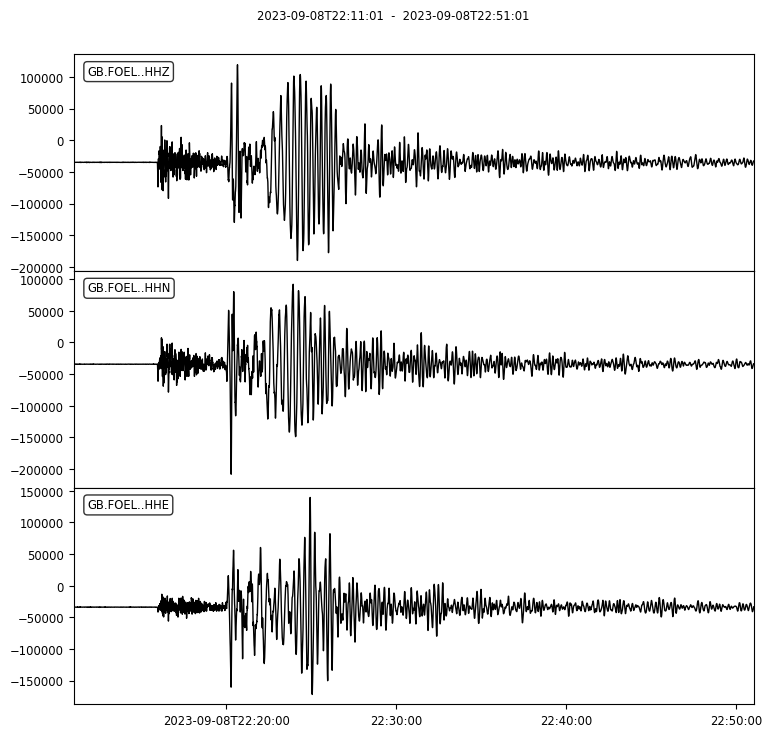

In [3]:
st.plot();

_Q1: In these records you can see body, Love, and Rayleigh wave arrivals, in that order.  (Somewhat unusually, the Love wave is particularly large on the vertical, HHZ, channel.)  Which arrival has the highest frequency content?  The lowest?_

_Your answer here._

### Part 2. Filter to particular frequency bands

Say we want to focus on high-frequency ground motion.  We can filter the data to focus on particular frequency bands.  There are many subtleties involved in exactly how you filter, but we'll use the approach that's built into obspy.  It's a good approach and makes things easy.

In the cell below, we filter to frequencies above 1 Hz and replot the data.   This is called highpass filtering. Note that we make a copy of the data first because the filtering happens in place---it modifies the signal that's already there.

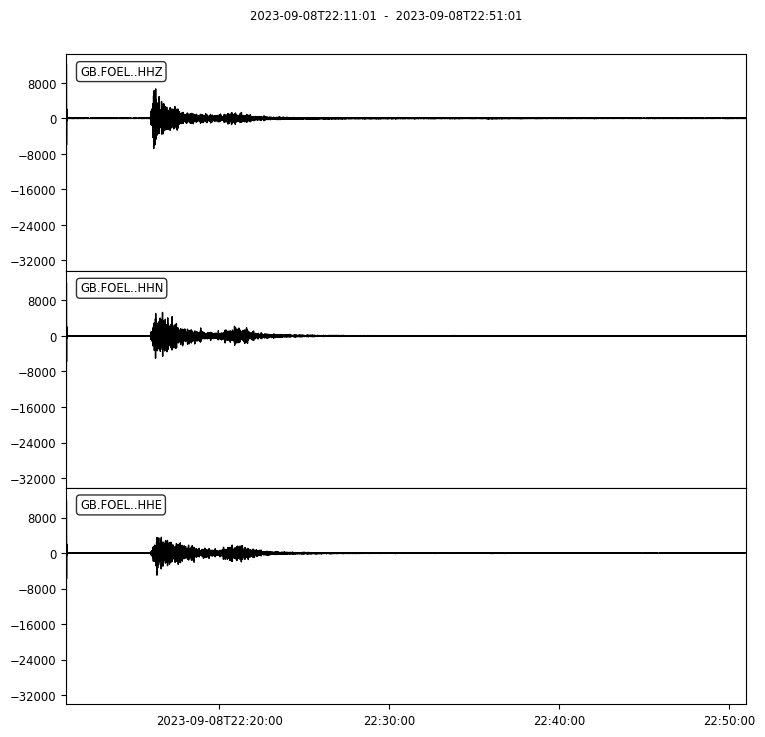

In [4]:
# make a copy
st_high=st.copy()

# remove variations at frequencies smaller than 1 Hz
st_high.filter('highpass',freq=1)

# plot the results
st_high.plot();

_Q2: There's not much surface wave signal anymore.  Is that what you expected? Why?_

_Your answer here_

If we want to do the opposite---to highlight low frequencies---we "lowpass" filter the data instead.  Try filtering the data to retain only frequencies lower than 0.5 Hz: periods longer than 2 s.  What do you see?

In [5]:
# make a copy so that you don't change the original data
st_low=st.copy()

# and filter
print('Your code here')

Your code here


Finally, we may want to highlight a particular frequency band---to "bandpass" filter the data.  In the cell below, we bandpass filter to retain frequencies between 0.01 and 0.05 Hz: periods between 20 and 100 s.

_Q3: Run the filter and take a look at the plots.  What makes sense?  What doesn't?_

_Your answer here._

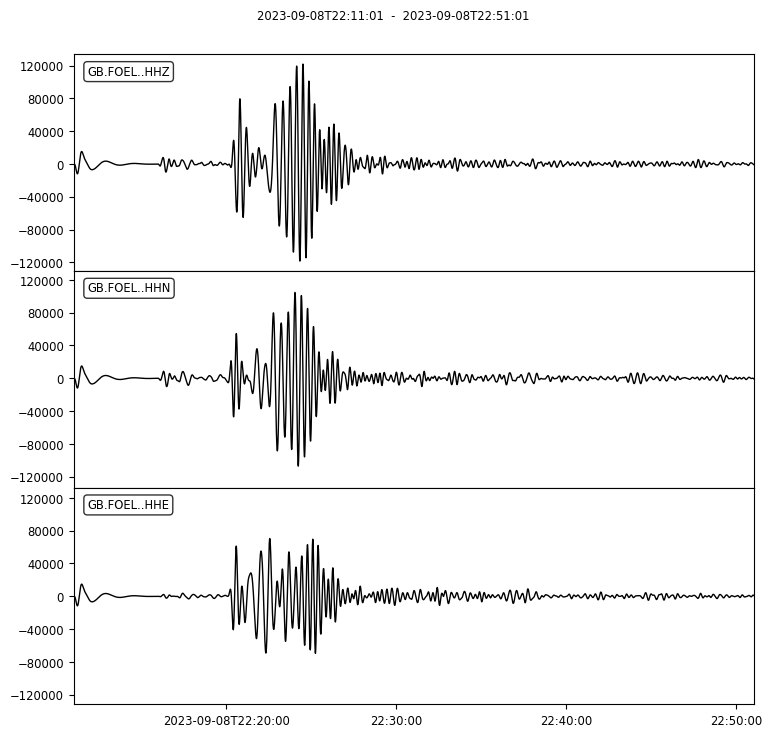

In [6]:
st_band=st.copy()
st_band.filter('bandpass',freqmin=0.01,freqmax=0.05)
st_band.plot();

### Part 3. Deal with edge effects

If you look carefully at the plot above, you'll notice that at the beginning of the filtered record, there's a large oscillation.  But if you back at the original record, there's no large oscillation at the beginning.  

This is an edge effect.  To understand what happened, let's look at the first minute of the unfiltered record.

start time 2023-09-08T22:11:01.000000Z


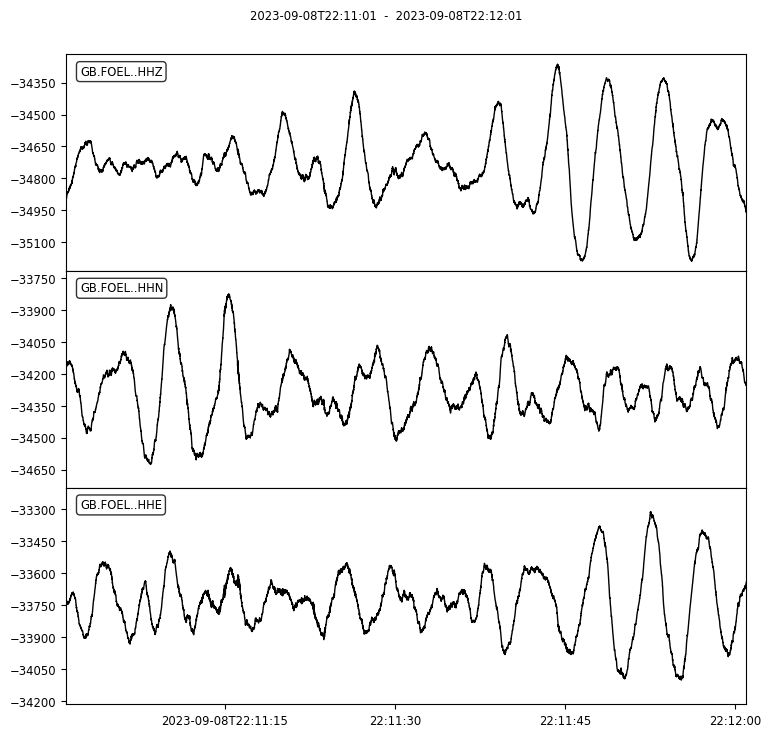

In [7]:
# grab the earliest start time from the records
# (though if you just wanted to say tstart=t1 for now, that's fine too)
tstart=np.min([tr.stats.starttime for tr in st])
print('start time',tstart)

st.plot(starttime=tstart,endtime=tstart+60);

Note that everything we see here is just noise.  The earthquake signal hasn't arrived yet.  That's not a problem---we can filter noise too.

And intuitively, you could just take these data and extract the frequencies you want.  However, because of the mathematical framework of filters, they can't technically act on short periods of data.  _Filters need the data to last from time negative infinity to time positive infinity._  When data isn't provided before or after a specified time, they (effectively) append zeros to the beginning and the end of the available time period.  

Let's look at what you see and what the filter is effectively acting on.  Note that the y-axis limits are different in the plots below.

what you see


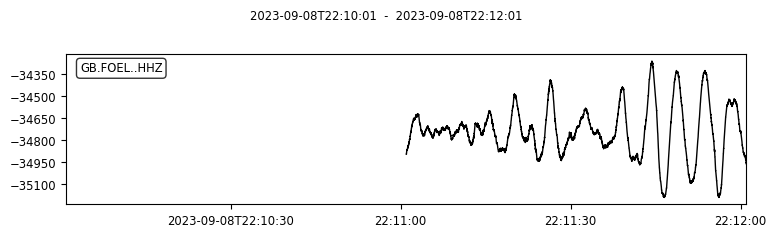

what the filter sees


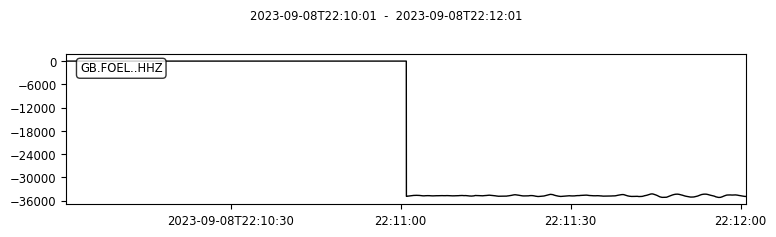

In [8]:
# the trace
tr_you=st.select(channel='HHZ')[0].copy()

# the trace that the filter might see
tr_filt=tr_you.copy()
tr_filt.data=np.append(np.zeros(10000),tr_filt.data)
tr_filt.stats.starttime=tr_filt.stats.starttime-tr_filt.stats.delta*10000

print('what you see')
tr_you.plot(starttime=tstart-60,endtime=tstart+60);
print('what the filter sees')
tr_filt.plot(starttime=tstart-60,endtime=tstart+60);

The problem is pretty obvious now.  The filter sees a huge step in the ground velocity at the beginning of the record.

Just to make sure that this is really the problem, let's try filtering the two records above.  Check that you retrieve the same thing.

what you see, filtered


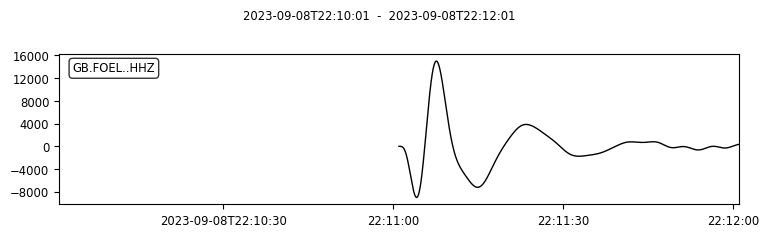

what the filter sees, after filtering


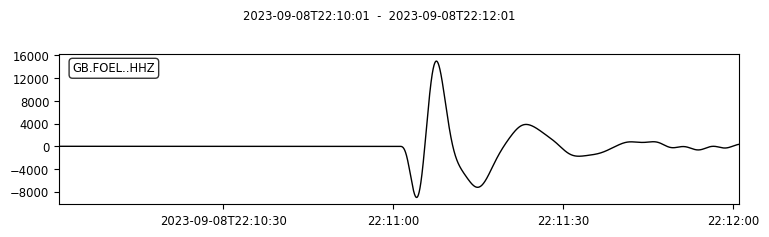

In [9]:
tr_filt.filter('bandpass',freqmin=0.05,freqmax=0.2)
tr_you.filter('bandpass',freqmin=0.05,freqmax=0.2)

print('what you see, filtered')
tr_you.plot(starttime=tstart-60,endtime=tstart+60,title='what you see');
print('what the filter sees, after filtering')
tr_filt.plot(starttime=tstart-60,endtime=tstart+60,title='what the filter sees');

### Grab a bit of the seismogram

To get rid of the large step at the edge of the record, we'll want to do two things: detrend and taper.  Both are easy.

To see how they work, though, it's useful to look at just a portion of the record.  Let's grab the first 200 seconds of the HHZ record.  Remember it's just noise, so there's no particular pattern.



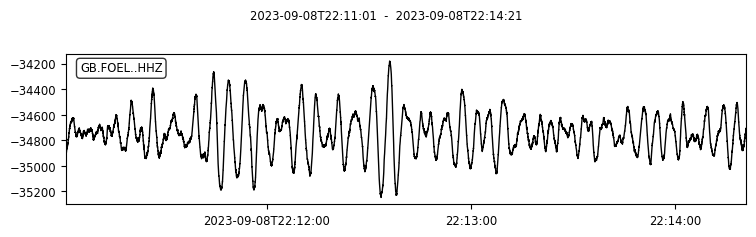

In [10]:
# first grab just one channel---we don't need them all
st_hhz=st.select(channel='HHZ')

# copy this channel, as trimming out bits will act "in place" and modify the record 
st_cutout=st_hhz.copy()

# and grab out 200 s of the data
st_cutout=st_cutout.trim(starttime=tstart,endtime=tstart+200)

st_cutout.plot();

_Q5: You'll want to grab different portions of the seismogram quite frequently, so make sure you can.  Extract the HHE seismogram from time 22:13:00 on 2023-09-08 until time 22:14:00 on 2023-09-08._

In [11]:
time1=obspy.UTCDateTime(2023,9,8,22,13,0)
#time2=...
print(time1)

print('Your code here')

2023-09-08T22:13:00.000000Z
Your code here


### Detrend

We want to make sure the data tends to zero at both ends.  So we'll take a simple, convenient approach to detrending, as built into obspy.  This approach creates a linear trend from the first value in the seismogram to the last value in the seismogram.  Then it subtracts that linear trend from the data.

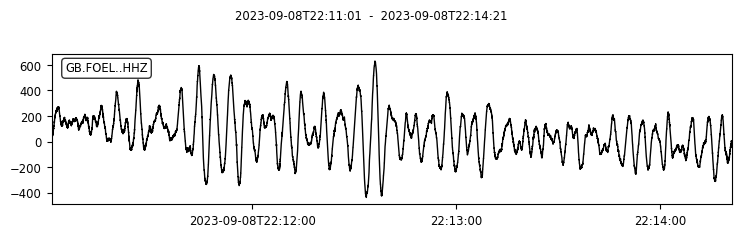

In [12]:
st_cutout.detrend()

st_cutout.plot();

_Q5: Check that the start and end values are zero and that the mean is now close to zero._

### Taper

Detrending makes sure that the seismogram starts and ends at zero, but we'd like a bit more.  We'd like the seismic amplitude to trend smoothly to zero at the beginning and the end.  To do so, we multiply by a taper: a function that's 1 in the middle and tends smoothly to zero at the edges.

The tapering in obspy is pretty simple.  Let's pick a taper where the edges---the tapering portion---are 40 s long.  We'll set the max_percentage value to 0.5; it doesn't matter for our purposes.

__Taper width:__ If you're bandpass or highpass filtering, it's good practice to make the taper at least twice as long as the longest period you're keeping.  So for a 1-Hz highpass, where you keep signals shorter than 1 s, you'd want your taper to be at least 2s long, if not longer.  (To achieve a 2-s-long taper, set max_length=2 below.) If you're lowpass filtering, you don't have the option of choosing longer tapers, but the taper doesn't matter so much for lowpass filtering.   You might choose tapers comparable the longest period that's commonly recorded in seismic data: around 200 s.


The original seismogram


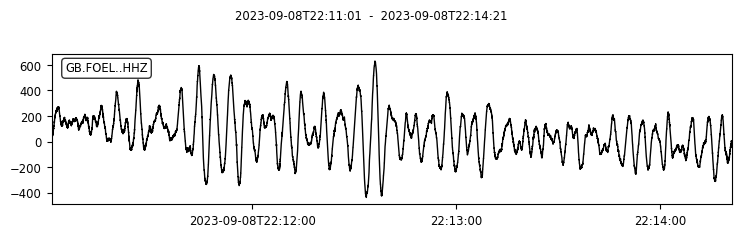

The taper we multiply by


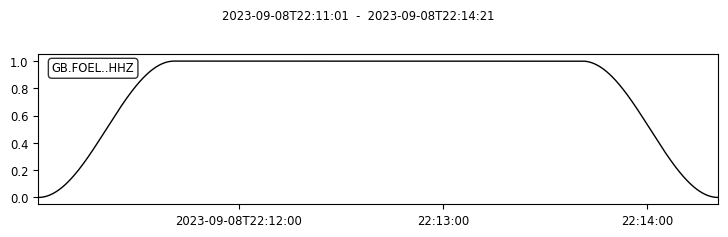

The tapered seismogram


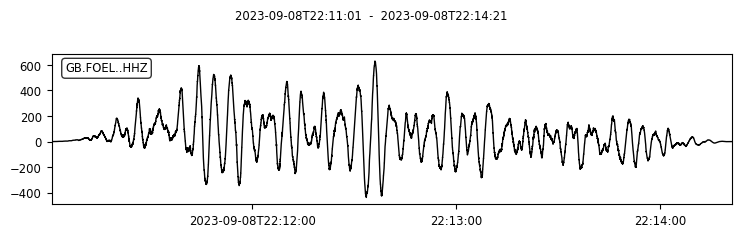

In [13]:
# copy and taper the original trace
st_cutout_tapered=st_cutout.copy()
st_cutout_tapered.taper(type='hann',max_length=40,max_percentage=0.5)

# and for illustration, make a seismogram that's originally all ones and taper that
taper=st_cutout.copy()
taper[0].data=np.ones(taper[0].stats.npts)
taper.taper(type='hann',max_length=40,max_percentage=0.5)

# plot them all
print('The original seismogram')
st_cutout.plot();

print('The taper we multiply by')
taper.plot();

print('The tapered seismogram')
st_cutout_tapered.plot();

In [14]:
# remember you can always get info about the functions you're using like this
help(st[0].taper)

Help on method taper in module obspy.core.trace:

taper(max_percentage, type='hann', max_length=None, side='both', **kwargs) method of obspy.core.trace.Trace instance
    Taper the trace.

    Optional (and sometimes necessary) options to the tapering function can
    be provided as kwargs. See respective function definitions in
    `Supported Methods`_ section below.

    :type type: str
    :param type: Type of taper to use for detrending. Defaults to
        ``'hann'``.  See the `Supported Methods`_ section below for
        further details.
    :type max_percentage: None, float
    :param max_percentage: Decimal percentage of taper at one end (ranging
        from 0. to 0.5).
    :type max_length: None, float
    :param max_length: Length of taper at one end in seconds.
    :type side: str
    :param side: Specify if both sides should be tapered (default, "both")
        or if only the left half ("left") or right half ("right") should be
        tapered.

    .. note::

        To 

### Try filtering again

Let's see what happens when we filter our detrended, tapered seismogram.

the detrended, tapered seismogram


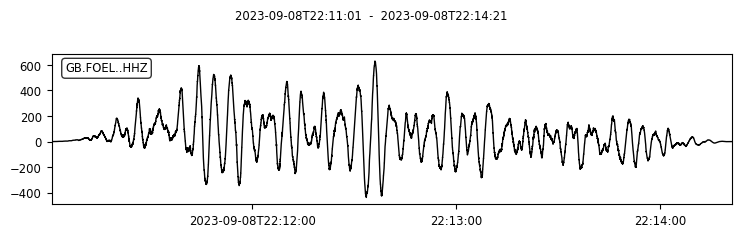

the detrended, tapered seismogram after filtering


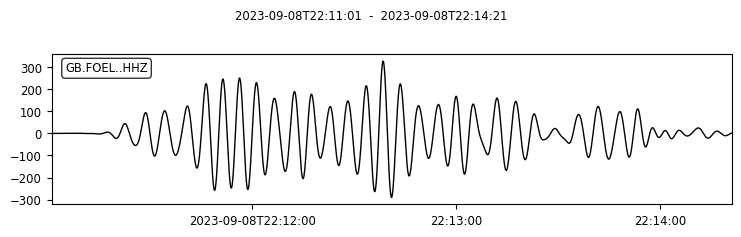

In [15]:
st_cutout_filt=st_cutout_tapered.copy()
st_cutout_filt.filter('bandpass',freqmin=0.05,freqmax=.2)

print('the detrended, tapered seismogram')
st_cutout_tapered.plot();
print('the detrended, tapered seismogram after filtering')
st_cutout_filt.plot();

No edge effects!

### Detrend, taper and filter the whole time series

To summarise, if we want to filter data, we should first detrend the data and taper it to zero at the edges.  It may have taken a while to get here, but in the end it's only a few lines of code. 

_Q5: Go back to your original seismograms, which had the edge effects in the filtering.  Try adding a detrend and a taper and filter again to get rid of the edge effects._

your code here
your code here


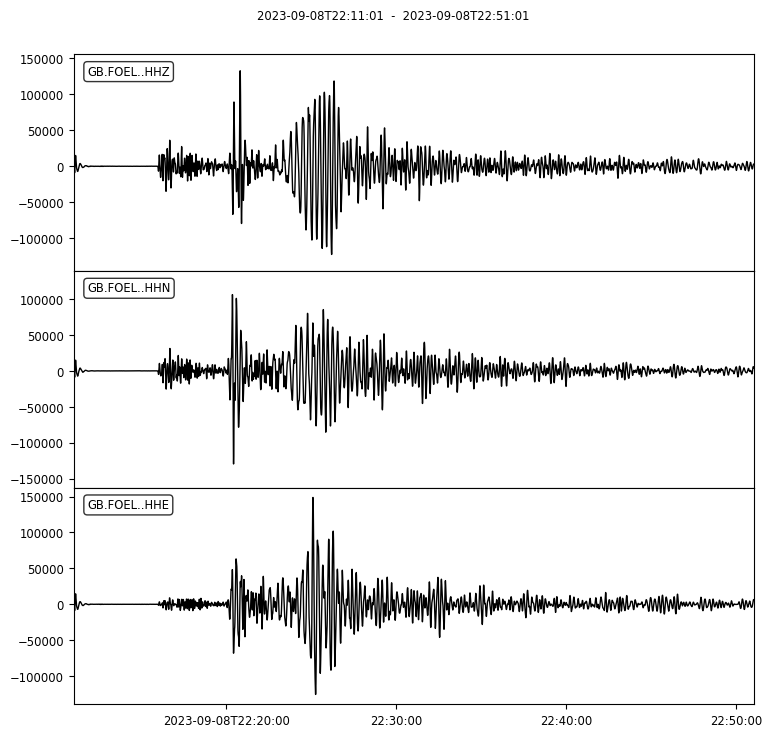

In [16]:
# copy the original seismogram
st_filt=st.copy()

# detrend
print('your code here')

# taper
print('your code here')

# filter
st_filt.filter('bandpass',freqmin=0.05,freqmax=0.2)

# and plot
st_filt.plot();

### Part 4. Discard data at the beginning and the end.

Detrending and tapering gets rid of edge effects.  But don't forget that you've now modified the beginning and the end of the seismogram!  So we can't use those bits of data anymore.  Trim the filtered seismogram to remove the beginning and the end.

You certainly want to remove any portion that you tapered, and any portion that might be modified by the taper.  So let's say you have a 40-s taper and then filtered to 0.05-0.2 Hz, keeping periods as long as 20 s.  Then you might want to remove at least 60=40+20 or 80=40+20$\times$2 s at the beginning and the end.


3 Trace(s) in Stream:
GB.FOEL..HHE | 2023-09-08T22:11:01.000000Z - 2023-09-08T22:51:01.000000Z | 100.0 Hz, 240001 samples
GB.FOEL..HHN | 2023-09-08T22:11:01.000000Z - 2023-09-08T22:51:01.000000Z | 100.0 Hz, 240001 samples
GB.FOEL..HHZ | 2023-09-08T22:11:01.000000Z - 2023-09-08T22:51:01.000000Z | 100.0 Hz, 240001 samples


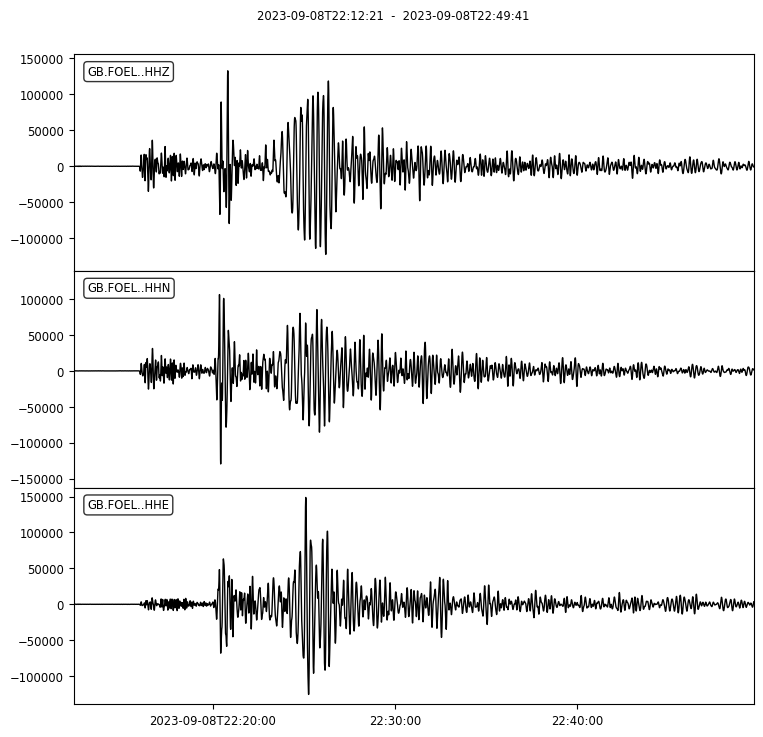

3 Trace(s) in Stream:
GB.FOEL..HHE | 2023-09-08T22:12:21.000000Z - 2023-09-08T22:49:41.000000Z | 100.0 Hz, 224001 samples
GB.FOEL..HHN | 2023-09-08T22:12:21.000000Z - 2023-09-08T22:49:41.000000Z | 100.0 Hz, 224001 samples
GB.FOEL..HHZ | 2023-09-08T22:12:21.000000Z - 2023-09-08T22:49:41.000000Z | 100.0 Hz, 224001 samples


In [17]:
# the start and end times of the traces
starttime=np.max([tr.stats.starttime for tr in st_filt])
endtime=np.min([tr.stats.endtime for tr in st_filt])

print(st_filt)

# trim to exclude the portions you have modified
st_filt.trim(starttime=starttime+80,endtime=endtime-80)

# and plot
st_filt.plot();
print(st_filt)

_Q6: Edit the cell above to change the portion of the data that's removed to what you think is appropriate.  Also compare the results of print(st_filt) commands.  Have the waveforms changed the way you expect?_